# Datathon Early Data Analysis

### Problem Statements 
- Identify 1000 products to be placed in the Instacart section in which 100 of these products are refridgerated and another 100 products are frozen. 
- Ensure that substitute items are as close to the originally requested item as possible. 
- Selected items must be able to fulfill a large portion of each order. 

In [1]:
# Import libraries 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

In [2]:
# Set the style for the visualizations in the notebook
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

In [3]:
# Load dataset 
df = pd.read_csv('mma_mart.csv')

### The dataset

The dataset that this notebook uses is provided by the Rotman MMA Datathon competition. 

In [4]:
# Inspect the attributes of the dataset 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 987259 entries, 0 to 987258
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   order_id       987259 non-null  int64 
 1   product_id     987259 non-null  int64 
 2   product_name   987259 non-null  object
 3   aisle_id       987259 non-null  int64 
 4   aisle          987259 non-null  object
 5   department_id  987259 non-null  int64 
 6   department     987259 non-null  object
dtypes: int64(4), object(3)
memory usage: 52.7+ MB


An intial exploration above shows that the dataset contains a total of 987,259 rows and 6 columns where each record stores information about a product requested in an Instacart order. 

The relationships between the attributes are summarized below:
- Each order ID contains multiple unique product ID. 
- Each product ID belongs to an aisle and a department. 
- An aisle have one to many products and belongs to one department only. 
- A department have one to many aisles and one to many products. 

In [5]:
# Check for null values in each column in the dataset
pd.isna(df).sum(axis=0)

order_id         0
product_id       0
product_name     0
aisle_id         0
aisle            0
department_id    0
department       0
dtype: int64

A check for null values show that the dataset does not contain any missing values. 

# 1. Products

The 'products' attribute in the dataset record the product IDs and product names of items purchased in each order. There is a total of 35,070 products found in this dataset. Since the product ID is unique to each product, a product only has one product ID in this dataset. 

In [6]:
# Number of unique product ids
print(f"There is a total of {df['product_id'].nunique()} unique products in the dataset.")

There is a total of 35070 unique products in the dataset.


In [7]:
# Check to find instances of a product id that associate with more than 1 product name 
sum(df.groupby('product_id')['product_name'].nunique() > 1)
# The test show that there are no product that has more than 1 product id/name associate with it

0

The graph below shows the top 20 products with the highest demand. A majority of the high demand products are all produce. 

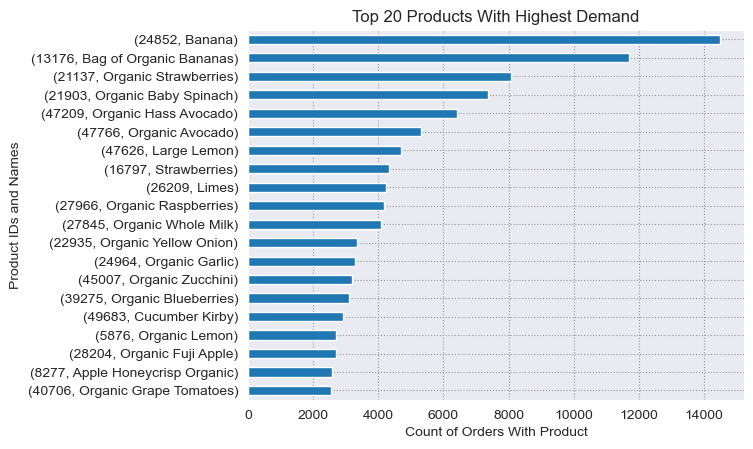

In [8]:
# Explore the list of unique products in the dataset 
df[['product_id','product_name']].value_counts()[:20].sort_values().plot(kind='barh')
plt.title('Top 20 Products With Highest Demand')
plt.ylabel('Product IDs and Names')
plt.xlabel('Count of Orders With Product')
plt.show()

# 2. Departments

The departments in the dataset represent the category that the products belong too. There is a total of 21 departments in the dataset where each department has its own unique department ID. 

In [9]:
# Explore the list of unique departments 
print(f"There is a total of {df['department_id'].nunique()} unique department in the dataset.")

There is a total of 21 unique department in the dataset.


In [10]:
# Number of unique department names 
print(f"There is a total of {df['department'].nunique()} unique department names in the dataset.")

There is a total of 21 unique department names in the dataset.


### 2.1 Departments with the highest demand are: produce, dairy eggs, and snacks

Similar to the findings above in the product section, the department with the highest demand is the produce department. In contrary, departments that does not sell food items are the least popular among Instacart customers. This findings also suggests that customers have higher demand for perishable items compared to household products that have a longer expiration. 

Surprisingly, the Meat and Seafood department has a low demand despite how protein plays an important role in the human diet. Compared to other grocery products' departments such as produce, dairy, pantry, bakery, dry goods pasta, etc. the Meat and Seafood department has very low demand from Instacart customers. 

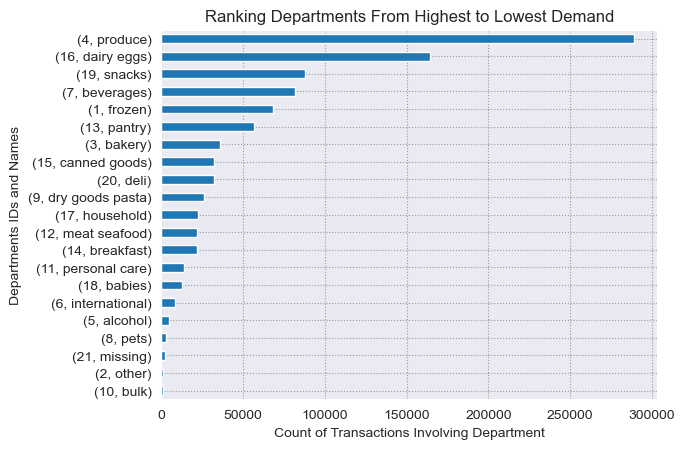

In [11]:
# Rank the departments by the highest to lowest volume of sales 
df[['department_id','department']].value_counts(ascending=True).plot(kind='barh')
plt.title('Ranking Departments From Highest to Lowest Demand')
plt.ylabel('Departments IDs and Names')
plt.xlabel('Count of Transactions Involving Department')
plt.show()

The charts below further show the top 10 best selling products in each department. 

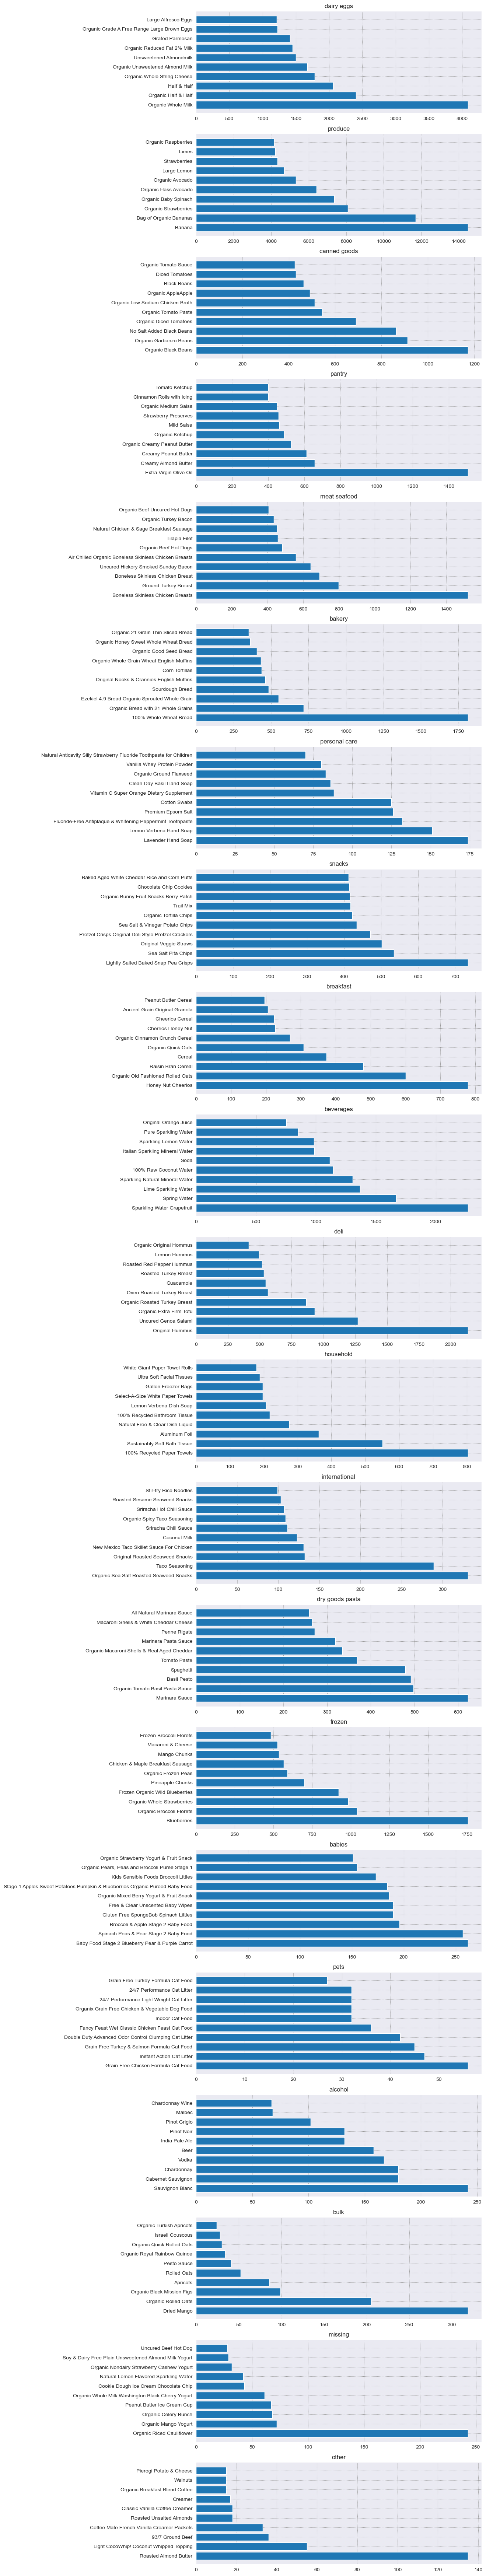

In [12]:
# Explore the top 10 most frequently purchased products in each department 
fig, ax = plt.subplots(df['department'].nunique(),1, figsize=(10,90))

for n, department in enumerate(df['department'].unique()):
    ax[n].barh(df[df['department'] == department]['product_name'].value_counts()[:10].index, df[df['department'] == department]['product_name'].value_counts()[:10].values)
    ax[n].set_title(department)

plt.show()

### 2.2 Departments with a large product selection are: snacks, pantry, and personal care

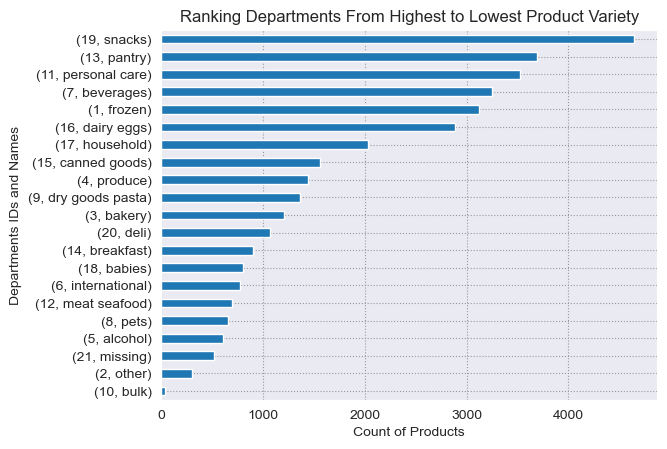

In [13]:
# Rank the departments by their product counts 
df.groupby(['department_id','department'])['product_id'].nunique().sort_values().plot(kind='barh')
plt.title('Ranking Departments From Highest to Lowest Product Variety')
plt.ylabel('Departments IDs and Names')
plt.xlabel('Count of Products')
plt.show()

The bar chart above shows that the snacks, pantry, and personal care department have the highest number of products. On the other hand, departments with ambiguous names such as missing, other, and bulk have the lowest number of products in the department. 

In comparison with the previous chart showing the demands for products in each department, there is a trend where a higher demand for products positively correlate to the large variety of product selections available in the department.  

### 2.3 Number of aisles in each department

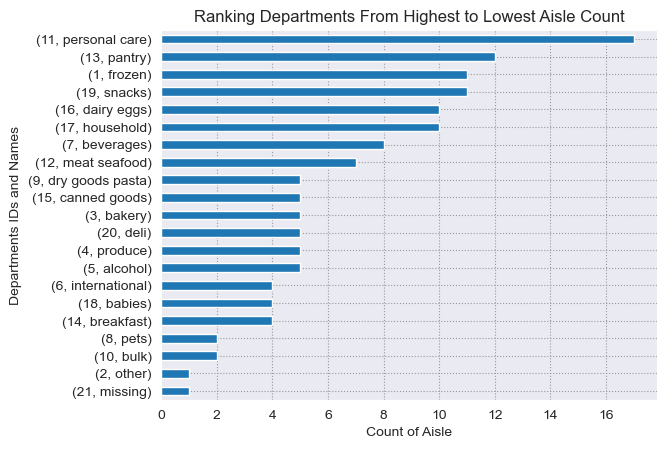

In [14]:
# Find number of aisles each department has 
df.groupby(['department_id','department'])['aisle_id'].nunique().sort_values().plot(kind='barh')
plt.title('Ranking Departments From Highest to Lowest Aisle Count')
plt.ylabel('Departments IDs and Names')
plt.xlabel('Count of Aisle')
plt.show()

The personal care, pantry, and frozen departments have the highest number of aisles in the supermarket. This suggests that the variety of products in these departments can be further divided into sub-groups with differing product categorizations. Especially, both this chart and the chart above indicate that departments with a large variety of product selections also tend to have a larger number of aisles dedicated to store these products. 

### 2.4 Ambiguous departments

While a majority of the department names are straight forward, there are some department names that are ambiguous. For instance, these department names are: "missing" and "other". To gain a better understanding of these ambiguous departments, let's explore the products that are associate with these departments. 

#### 2.4.1 Missing Department

Assuming that the items labeled with a 'missing' department and aisle are missing items that the personal shopper cannot find, I will further explore which product is hardest to find and whether a similar substitute is included in the order with the missing item or not. 

In [15]:
# Find products that belong to the ambiguous departments 
df[df['department'] == 'missing']

,order_id,product_id,product_name,aisle_id,aisle,department_id,department
654,75,44077,Tomato Basil Bisque Soup,100,missing,21,missing
1511,154,41801,Cold Pressed Watermelon & Lemon Juice Blend,100,missing,21,missing
1512,154,11806,Paleo Blueberry Muffin,100,missing,21,missing
2126,226,47307,"Magic Tape Refillable Dispenser 3/4\"" x 850\""",100,missing,21,missing
4121,420,7456,Organic Poblano Pepper,100,missing,21,missing
...,...,...,...,...,...,...,...
986067,99887,17550,Oatneal Cookie Ice Cream,100,missing,21,missing
986086,99890,13339,Dairy Free Unsweetened Almond Milk Beverage,100,missing,21,missing
986103,99890,37307,Organic Asian Chopped Salad Kit,100,missing,21,missing
986275,99905,17628,Lemon Bag,100,missing,21,missing


In [16]:
# Find number of products associated with the 'missing' department 
df[df['department'] == 'missing']['product_id'].nunique()

518

There is a total of 518 unique products that are labelled as 'missing'. 

In [17]:
# Retrieve the list of product ids belonging to the products found in the 'missing' department 
missing_products = df[df['department'] == 'missing']['product_id'].unique()

In [18]:
# Find other departments that these products also appear in 
other_dept = {}
for i in range(len(df)):
    if df['product_id'][i] in missing_products:
        if df['department'][i] != 'missing':
            other_dept[df['product_id'][i]] = df['department'][i]
    
# Products in the missing department does not appear in any other department 

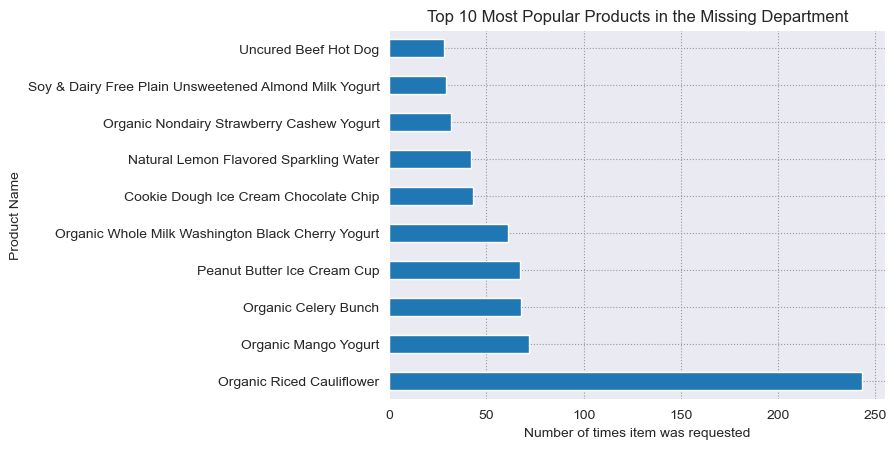

In [19]:
# Find the products with the highest demand in the missing aisle/department 
df[df['department'] == 'missing']['product_name'].value_counts()[:10].plot(kind='barh')
plt.title('Top 10 Most Popular Products in the Missing Department')
plt.xlabel('Number of times item was requested')
plt.ylabel('Product Name')
plt.show()

The bar chart above shows the names of products labelled as 'missing' and the number of times they were requested by the customers. 

#### 2.4.2 Other Department

Similar to the 'missing' department, the 'other' department also contain items that are not located in a specific aisle or department. Unlike the missing items, it is unclear whether these items were obtained for the Instacart customers or not. 

In [20]:
# Find number of products associated with the 'other' department 
df[df['department'] == 'other']['product_id'].nunique()

303

There is a total of 282 unique products with department and aisle labelled as 'other' in the dataset. 

In [21]:
# Explore orders with an 'Other' department 
df[df['department'] == 'other']

,order_id,product_id,product_name,aisle_id,aisle,department_id,department
691,79,39461,Coffee Mate French Vanilla Creamer Packets,6,other,2,other
1077,109,36066,SleepGels Nighttime Sleep Aid,6,other,2,other
1926,202,20406,Roasted Unsalted Almonds,6,other,2,other
1985,210,86,"Camilia, Single Liquid Doses",6,other,2,other
2127,226,36291,Maximum Strength Original Paste Diaper Rash Oi...,6,other,2,other
...,...,...,...,...,...,...,...
983992,99665,20406,Roasted Unsalted Almonds,6,other,2,other
984112,99678,45071,Boneless Pork Tenderloin,6,other,2,other
984515,99721,38662,Roasted Almond Butter,6,other,2,other
984534,99723,26756,Light CocoWhip! Coconut Whipped Topping,6,other,2,other


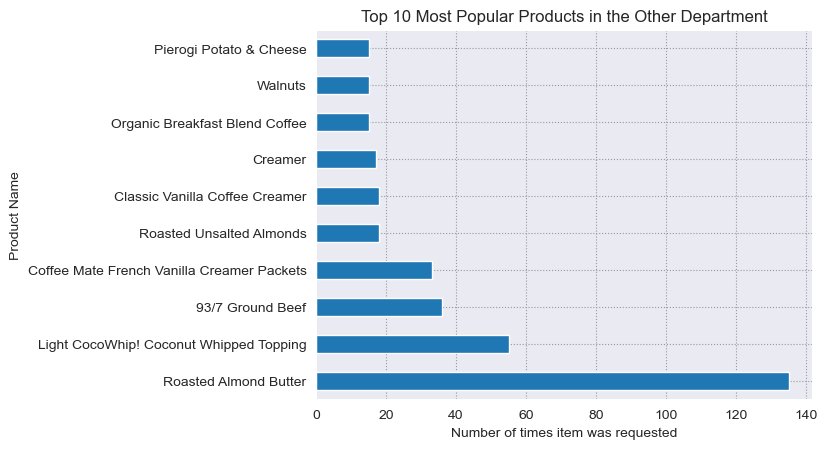

In [22]:
# Find the products with the highest demand in the other aisle/department 
df[df['department'] == 'other']['product_name'].value_counts()[:10].plot(kind='barh')
plt.title('Top 10 Most Popular Products in the Other Department')
plt.xlabel('Number of times item was requested')
plt.ylabel('Product Name')
plt.show()

# 3. Aisles

There is a total of 134 different aisle in the supermarket. Each aisle in the supermarket has its own unique name as shown by the test for unique values below. 

In [23]:
# Find the number of unique aisle in the supermarket 
print(f"The total number of unique aisle in the supermarket is {df['aisle_id'].nunique()}.")

The total number of unique aisle in the supermarket is 134.


In [24]:
# Find the number of unique aisle in the supermarket 
print(f"The total number of unique aisle names in the supermarket is {df['aisle'].nunique()}.")

The total number of unique aisle names in the supermarket is 134.


In [25]:
# Find the number of products each aisle store
df.groupby(['aisle'])['product_id'].nunique().describe()

count    134.000000
mean     261.716418
std      191.668009
min       12.000000
25%      120.000000
50%      216.000000
75%      346.750000
max      874.000000
Name: product_id, dtype: float64

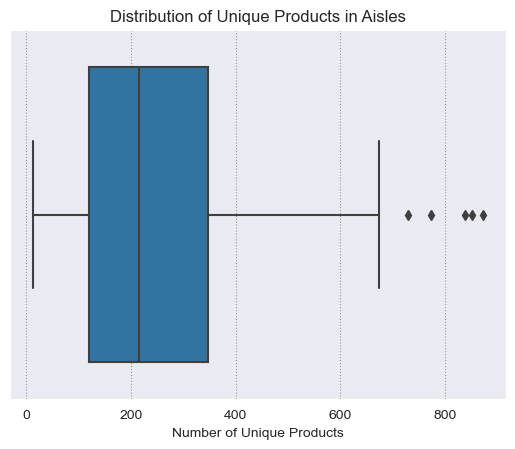

In [26]:
# Plot box and whisker plot to show the distribution of products in the aisles
aisle_products_count = pd.DataFrame(data=df.groupby('aisle')['product_id'].nunique().values, columns=['products_count'])

sns.boxplot(data=aisle_products_count, x='products_count')
plt.title('Distribution of Unique Products in Aisles')
plt.xlabel('Number of Unique Products')
plt.show()

The aisle with the most products have a total of 874 products displayed in the aisle. On the other hand, the aisle with the least number of products contain 12 products. On average, each aisle contain in the supermarket hold 261 products. 

Next, I will explore the customers' demands for products from the aisles. The two chart below show the top 10 aisles with lowest demand and top 10 aisles with the highest demand from Instacart customers. 

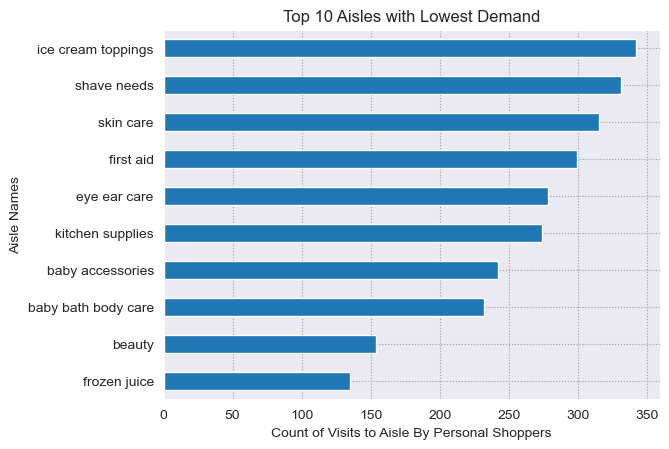

In [27]:
# Find least visited aisle
df['aisle'].value_counts(ascending=True)[:10].plot(kind='barh')
plt.title('Top 10 Aisles with Lowest Demand')
plt.ylabel('Aisle Names')
plt.xlabel('Count of Visits to Aisle By Personal Shoppers')
plt.show()

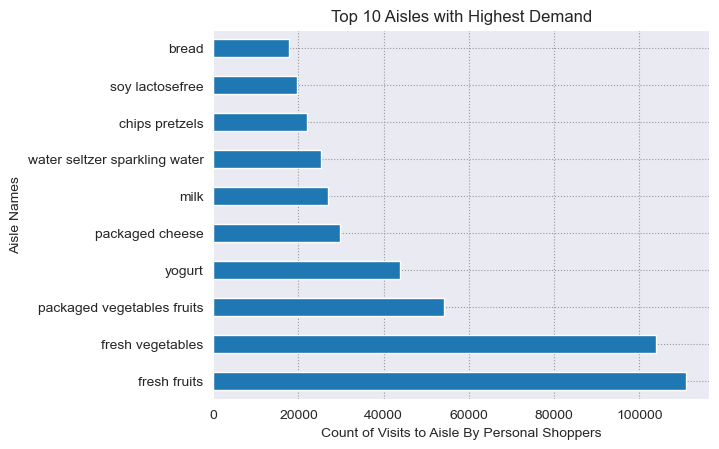

In [28]:
# Most frequently visited aisle
df['aisle'].value_counts(ascending=False)[:10].plot(kind='barh')
plt.title('Top 10 Aisles with Highest Demand')
plt.ylabel('Aisle Names')
plt.xlabel('Count of Visits to Aisle By Personal Shoppers')
plt.show()

As shown by the top 10 aisles with the highest demand above, the fresh fruits, fresh vegetables and packaged vegetables fruits aisles are frequently visited by personal shoppers to fulfill orders. Especially, the yoghurt and packaged cheese in this chart also happen to be two of the aisles with the highest products variety. Overall, these aisles with the highest demand all carry food items which further suggest that customers frequently demand food products. Thereby, the Instacart section must have a reasonable amount of fresh food items available for personal shoppers to fulfill high demand from customers. 

# 4. Order

Overall, there is a total of 97,833 orders in the dataset. On average, each order contains 10 products. While a majority of orders contain around 14 products, there is an outlier in the dataset with a total of 127 items placed in the order. Since this outlier is skewed, I will further investigate which items are included in this order and whether this outlier should be removed from the dataset or not. 

In [29]:
# Total number of orders in the dataset 
print(f"There is a total of {df['order_id'].nunique()} orders in the dataset.")

There is a total of 97833 orders in the dataset.


### 4.1 Order sizes

The order sizes refer to how many products an order contain. To calculate the order sizes, I grouped the orders by their unique order IDs then count the number of unique products associated with each order. 

In [30]:
# Find the maximum, minimum, and average number of products included in each order
# by grouping by order_id the count the number of unique product_id associated with each order
df.groupby('order_id')['product_id'].nunique().describe()

count    97833.000000
mean        10.091268
std          7.539181
min          1.000000
25%          5.000000
50%          8.000000
75%         14.000000
max        127.000000
Name: product_id, dtype: float64

In [31]:
# Create a dataframe to store the order ID and the total number of products associated with the order
order_id = pd.DataFrame(data=np.array(df.groupby('order_id')['product_id'].nunique().index), columns=['order_id'])
products_count = pd.DataFrame(data=df.groupby('order_id')['product_id'].nunique().values, columns=['products_count'])
order_size = pd.concat([order_id, products_count], axis=1)

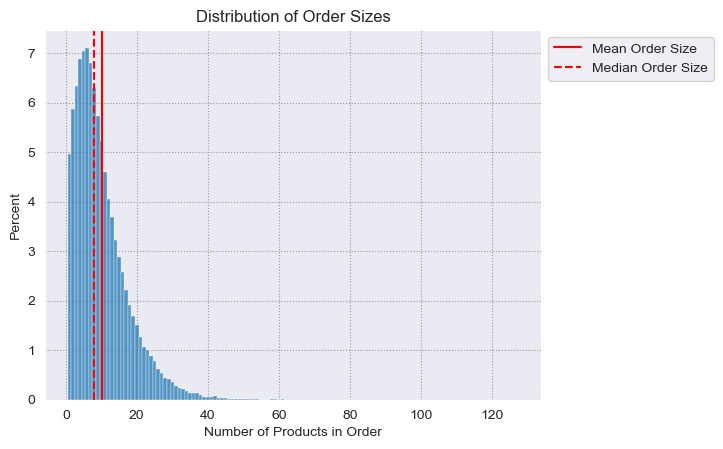

In [32]:
# Visualize the order sizes in the dataset 
sns.histplot(data=order_size, x='products_count', stat='percent', discrete=True)
plt.title('Distribution of Order Sizes')
plt.xlabel('Number of Products in Order')
plt.axvline(x=order_size['products_count'].mean(), color='red', label='Mean Order Size')
plt.axvline(x=order_size['products_count'].median(), color='red', label='Median Order Size', linestyle='--')
plt.legend(bbox_to_anchor = (1.0, 1), loc = 'upper left')
plt.show()

As shown by the histogram above, the distribution of order sizes in the dataset is right skewed, meaning that a large portion of orders are small orders with less than 10 items. 

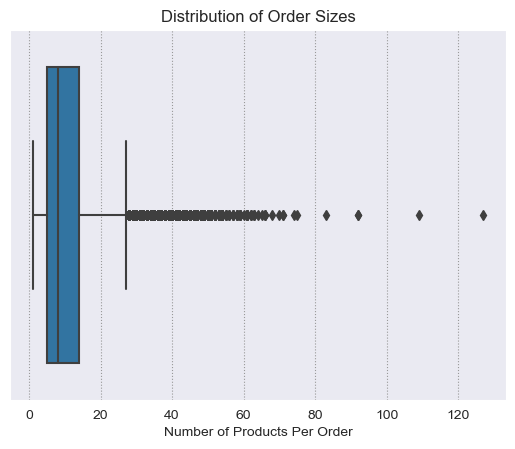

In [33]:
# Plot the histogram showing the order sizes distribution
sns.boxplot(data=order_size, x='products_count')
plt.title('Distribution of Order Sizes')
plt.xlabel('Number of Products Per Order')
plt.show()

The box and whisker plot above further shows the group of outliers in the dataset and the number of products that they contain. Note that any data points that lies above the maximum indicated by the whisker on the right will be considered an outlier in this analysis. 

To further investigate the outliers, I will pick out the most extreme outliers with a maximum order size of 127 products to explore the number of aisles and departments that carry the items requested in this large order. 

In [34]:
# Investigate the items found in the outlier order with 127 items 
large_order = df[df['order_id'] == order_size[order_size['products_count'] == 127]['order_id'].values[0]]
# Find the number of aisles the products requested in the large order belong to 
aisle_count = large_order['aisle_id'].nunique()
# Find the number of departments the products requested in the large order belong to
dept_count = large_order['aisle_id'].nunique()

print(f'The items requested in the large order with 127 products come from {aisle_count} aisles and {dept_count} departments.')

The items requested in the large order with 127 products come from 41 aisles and 41 departments.


The findings above regarding the extreme outlier suggests that this order is highly unsual compared to the rest of the orders in the dataset since not only the count of products in the order is high but the number of aisles and departments associated with the order is also very high. 

Thus, before removing these outliers, I need to calculate the portion of the dataset that they made up to avoid removing too much data which could have been relevant for building the machine learning model. 

In [35]:
# Calculate the portion of the dataset that the outliers are accounted for 
max_whisker = order_size['products_count'].quantile(0.75) + 1.5*(order_size['products_count'].quantile(0.75)- order_size['products_count'].quantile(0.25))
outlier_orders = order_size['products_count'] > int(max_whisker)
percent_outliers = outlier_orders.mean()

print(f"The outliers made up of {int(percent_outliers*100)}% of the orders in the dataset.")

The outliers made up of 3% of the orders in the dataset.


Since the outliers only account for only 3% of the orders in the dataset, I will remove these orders. 

In [36]:
# Find the order_id belonging to the outliers
outlier_order_id = order_size[outlier_orders]['order_id'].values

# Check that the number of orders returned match with the number of outlier orders calculated in the previous section 
len(outlier_order_id) == outlier_orders.sum()

True

In [37]:
# Find the indices of the rows that are relevant to the outliers orders by using a nested for-loop
outlier_order_index = []

for i in outlier_order_id:
    l = df[df['order_id'] == i].index.values
    for item in l:
        outlier_order_index.append(item)

In [38]:
# Remove the outliers from the dataset
df = df.drop(outlier_order_index)

To ensure that the outliers are correctly removed, a histogram will be plotted again to show the distribution of order sizes in the dataset. 

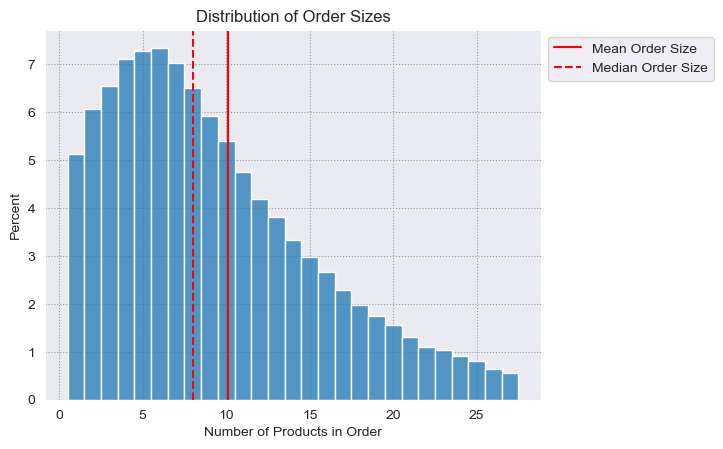

In [39]:
# Plot the histogram showing the order sizes distribution after the outlier is removed
order_size_2 = pd.DataFrame(data=df.groupby('order_id')['product_id'].nunique().values, index=df.groupby('order_id')['product_id'].nunique().index, columns=['products_count'])

sns.histplot(data=order_size_2, x='products_count', stat='percent', discrete=True)
plt.title('Distribution of Order Sizes')
plt.xlabel('Number of Products in Order')
plt.axvline(x=order_size['products_count'].mean(), color='red', label='Mean Order Size')
plt.axvline(x=order_size['products_count'].median(), color='red', label='Median Order Size', linestyle='--')
plt.legend(bbox_to_anchor = (1.0, 1), loc = 'upper left')
plt.show()

The data is less skewed after the outliers are removed. Now we can see more clearly that a majority of the orders' sizes are relatively small with a median of 8 items and an average of 10 items per order. 

### 4.2 Number of aisles and departments associated with an order

The number of aisles or departments associated with an order refers to the total number of aisle/department that the products requested in a single order belonged to. 

In [40]:
# Find number of aisles a personal shopper needed to visit to fulfill an Instacart order
df.groupby('order_id')['aisle_id'].nunique().describe()

count    94653.000000
mean         6.834913
std          4.127657
min          1.000000
25%          4.000000
50%          6.000000
75%          9.000000
max         25.000000
Name: aisle_id, dtype: float64

On average, a personal shopper need to visit 6 different aisle to fulfill a Instacart order. The highest number of aisle a personal shopper needed to visit is 25 and the lowest number of aisle the personal shopper needed to visit is 1. 

In [41]:
# Find number of departments a personal shopper needed to visit to fulfill an Instacart order
df.groupby('order_id')['department_id'].nunique().describe()

count    94653.000000
mean         4.568318
std          2.382996
min          1.000000
25%          3.000000
50%          4.000000
75%          6.000000
max         15.000000
Name: department_id, dtype: float64

As shown by the data above, a personal shopper needed to visit an average of 4 different departments every time they fulfill an Instacart order. 

After inspecting the orders, we can identify the major pain point that Instacart's personal shoppers face is the need to visit many aisles in differing department in a supermarket to fulfill an order. Thus, the personal shoppers can fulfill orders more quickly if they can limit their time spent searching through different aisles and departments in the supermarket.  

### 4.3 Most visited department for each order

Next, I will find the number of orders that require at least one visit to a department. The most popular department among the orders would be the department that has the highest number of visits. Note that different from the calculation of the most popular department above based on the volume of transactions for each product ordered, this calculation for the most popular department is based on the volume of orders instead. 

In [42]:
# Create a dummy variable for each department 
dept_dummies = pd.get_dummies(df['department'])

In [43]:
# Add the order number to the department dummies dataframe 
dept_dummies = pd.concat([df['order_id'], dept_dummies], axis=1)

In [44]:
# Find unique order ID that associated with visits to each department 
# Create an empty dictionary to store the count of orders 
num_order = {}
# Looping through the name of each department 
for dept in df['department'].unique():
    num_order[dept] = dept_dummies.groupby(dept)['order_id'].nunique()[1]

# Create a dataframe to view the count of orders each department have
dept_order_count = pd.DataFrame.from_dict(num_order, orient='index', columns=['order_count'])

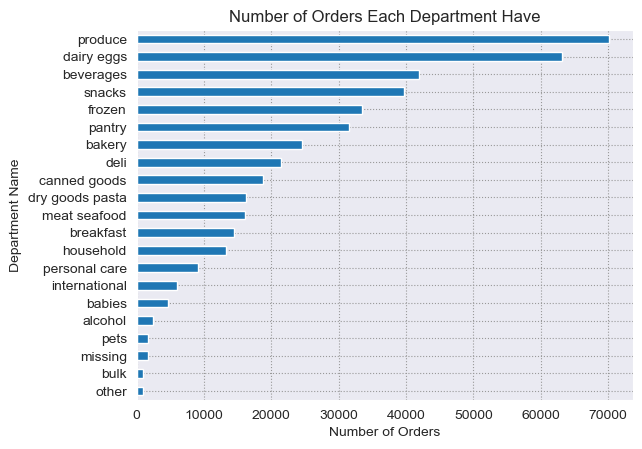

In [45]:
# Plot a bar chart to show the count of orders each department have 
dept_order_count['order_count'].sort_values().plot(kind='barh')
plt.title('Number of Orders Each Department Have')
plt.xlabel('Number of Orders')
plt.ylabel('Department Name')
plt.show()

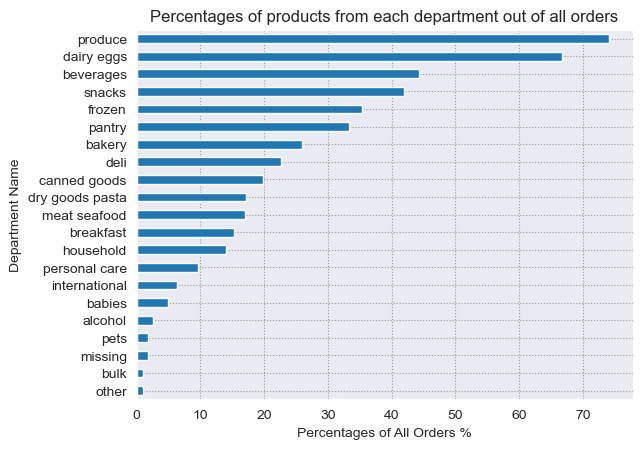

In [46]:
# Plot a bar chart to show the percentages of orders that contain a product from each department out of all orders
percent_order = dept_order_count['order_count']/df['order_id'].nunique()*100 
percent_order.sort_values().plot(kind='barh')
plt.title('Percentages of products from each department out of all orders')
plt.xlabel('Percentages of All Orders %')
plt.ylabel('Department Name')
plt.show()

The chart above shows that almost 3 out of 4 orders in the dataset include at least one product from the produce department. In addition, approximately 13 out of 20 orders include at least one product from the dairy eggs department. Beverages and snacks are also in high demand where roughly 2 out of 5 orders include at least one product from these departments. 

# 5. Market Basket Analysis

The market basket analysis will be carried out to find products that are frequently purchased and a complimentary item that accompanied it. Since the previous early data analysis suggests that groceries items such as produces (vegetables, fruits...) have the highest demand, I expect that these popular items would also appear as the most popular products in the market basket analysis again. 

In [47]:
# Reformat the dataset to have a list of purchased items in an order for each row 
basket_df = pd.DataFrame(df.groupby('order_id')['product_name'].unique().values, columns=['order'])

In [48]:
# Import the transaction encoder function from mlxtend
from mlxtend.preprocessing import TransactionEncoder

In [49]:
# Instantiate transaction encoder and identify unique items in transactions
encoder = TransactionEncoder().fit(basket_df['order'].values)

# One-hot encode transactions
onehot = encoder.transform(basket_df['order'].values)

# Convert one-hot encoded data to DataFrame
onehot = pd.DataFrame(onehot, columns = encoder.columns_)

### Apriori Principles

The Apriori algorithm will be used to analyze the basket by identifying frequently occuring products and ignoring products that are low in demand when calculating the support ratio between two items. A support ratio measures the probability of two products being purchased together. The higher the support value, the higher the chances that buying the first product will lead to the purchase of the second product. 

Other metrics that are also used to support the support value are: lift and confidence. 

In [50]:
# Import Apriori algorithm from mlxtend
from mlxtend.frequent_patterns import apriori, association_rules

In [51]:
# Compute frequent itemsets
frequent_itemsets = apriori(onehot, min_support=0.005, max_len=2, use_colnames=True)
len(frequent_itemsets)

283

In [52]:
# Compute standard metrics
rules = association_rules(frequent_itemsets, metric='confidence', min_threshold= 0.05)
len(rules)

95

In [53]:
# Import parallel coordinates from pandas plotting
from pandas.plotting import parallel_coordinates

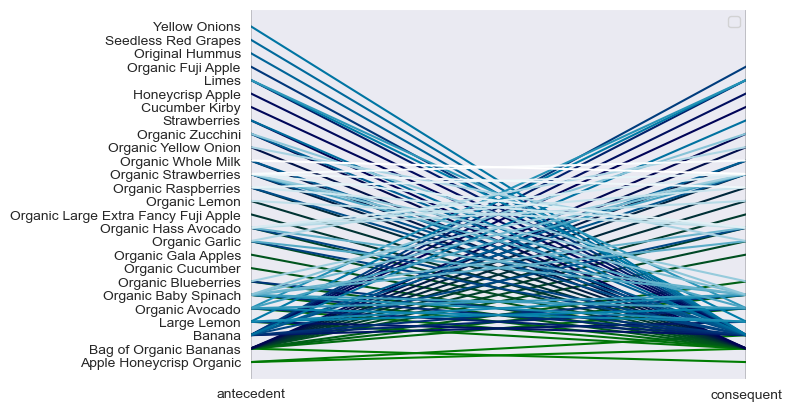

In [54]:
# Convert rules into coordinates suitable for use in a parallel coordinates plot
rules['antecedent'] = rules['antecedents'].apply(lambda antecedent: list(antecedent)[0])
rules['consequent'] = rules['consequents'].apply(lambda consequent: list(consequent)[0])
rules['rule'] = rules.index
coords = rules[['antecedent', 'consequent', 'rule']]

# Generate parallel coordinates plot
parallel_coordinates(coords, 'rule', colormap='ocean')
plt.legend([])
plt.show()

The results generated by the Apriori algorithm suggests that 'Bags of Organic Bananas' is a highly popular product which is often purchased with other produce as shown by the density of the green lines in the parallel coordinates plot above. Other produce such as apples, spinach, avocado, and blueberries are also popular products that are frequently purchased with other vegetables/fruits item. Note that a majority of these products are labelled as 'organic' which further indicates that customers who purchase organic products are likely to purchase other organic products rather than non-organic produce items. 

# 6. Natural Language Processing With Product Names

In this section, I will use an NLP model to analyze the products name to gain more insight into frequently purchased product types and how the products can be better categorized. 

In [55]:
# Use Scikit-Learn's vectorizer to transform the product names into a sparse matrix for occuring frequencies analysis
# Import Scikit-Learn's Count Vectorizer 
from sklearn.feature_extraction.text import CountVectorizer


# Instantiate the count vectorizer 
# Set the parameters to convert all characters into lower case letters before tokenizing 
# Only include words with an occuring frequency of at least 2% of the dataset
# Set an n-gram value of 1 to extract 1 word in a product name 
bagofwords = CountVectorizer(lowercase=True, min_df = 0.02, ngram_range=(1,1)).fit(df['product_name'].values)

# Fit and transform the product names by using the vectorizer 
transform = bagofwords.transform(df['product_name'].values)

In [56]:
# Create a dataframe to store the count vectorizer outputs 
products_cv = pd.DataFrame({'product_name': bagofwords.get_feature_names_out(), 'frequency': transform.toarray().sum(axis=0)})

# Sort the frequency count in descending order 
products_cv = products_cv.sort_values(by='frequency', ascending=False)

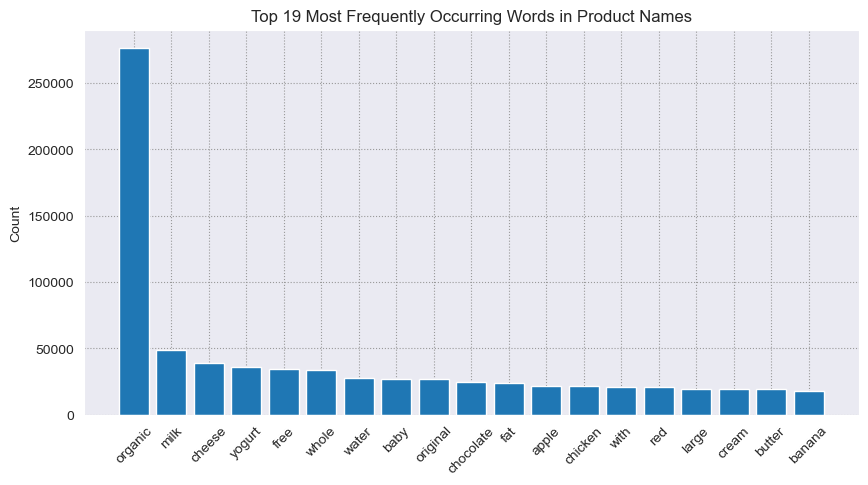

In [57]:
# Plot a bar chart to show the product names with the highest occurances 
plt.figure(figsize=(10,5))
plt.bar(products_cv['product_name'], products_cv['frequency'])
plt.title(f"Top {products_cv.shape[0]} Most Frequently Occurring Words in Product Names")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

The count plot above shows that Instacart customers have a relatively high preference for organic products. Other than the term 'organic', other frequently occuring words in the product names show that milk, cheese, yoghurt, chocolate, apple, chicken. cream, butter, and banana are also types of products that have high demand. 

Below, I will repeat the NLP model to explore the words with high frequency that often appear together in the customers' orders. 

In [58]:
# Instantiate the count vectorizer 
# Set the parameters to convert all characters into lower case letters before tokenizing 
# Only include words with an occuring frequency of at least 1% of the dataset
# Set an n-gram value of 2 to extract 2 word in a product name 
bagofwords_2 = CountVectorizer(lowercase=True, min_df = 0.01, ngram_range=(2,2)).fit(df['product_name'].values)

# Fit and transform the product names by using the vectorizer 
transform_2 = bagofwords_2.transform(df['product_name'].values)

In [59]:
# Create a dataframe to store the count vectorizer outputs 
products_cv_2 = pd.DataFrame({'product_name': bagofwords_2.get_feature_names_out(), 'frequency': transform_2.toarray().sum(axis=0)})

# Sort the frequency count in descending order 
products_cv_2 = products_cv_2.sort_values(by='frequency', ascending=False)

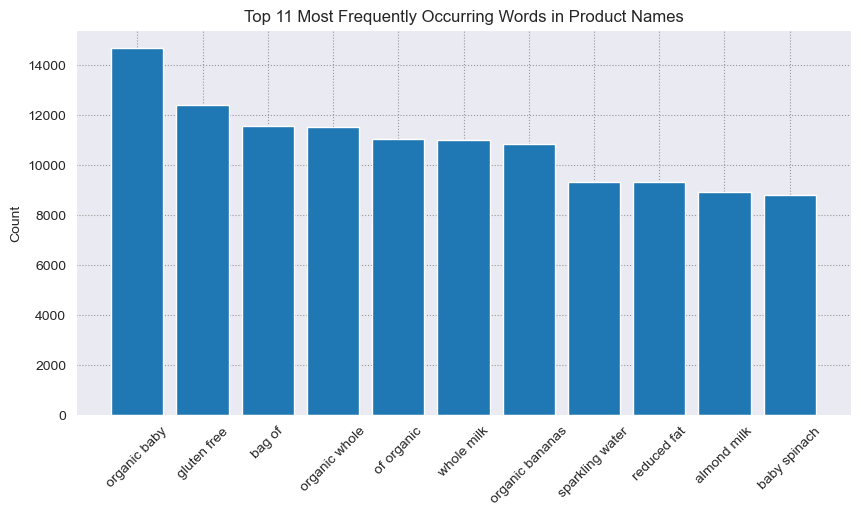

In [60]:
# Plot a bar chart to show the words with the highest occurances in product names
plt.figure(figsize=(10,5))
plt.bar(products_cv_2['product_name'], products_cv_2['frequency'])
plt.title(f"Top {products_cv_2.shape[0]} Most Frequently Occurring Words in Product Names")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

The findings in the chart above further elaborate on the type of organic produces that are popular among customers which happen to be 'organic baby' vegetables/fruits or 'organic whole' produces. In addition, items that are 'gluten free' or have 'reduced fat' also have high demand. In term of specific product items, whole milk, organic bananas, sparkling water, almond milk, and baby spinach are the most popular. Note that relative to all the orders in the datasets, these product names appear in at least 1%  of all products ordered. 

Overall, the NLP models highlight that produce is a major product category for customers. Additionally, customers have a high preference for organic, gluten-free, and reduced fat products when it comes to produce. 

# 7. Feature engineering 

In this section, I will build upon the insights gathered from the previous sections to create relevant features that may improve the performance of the machine learning models. 

## 7.1 Frozen Items

Since the problem statement states that only 100 frozen items can be included in the Instacart aisle, the frozen items need to be labelled in the dataset to aid with the selection process. 

The following assumptions were made to label the frozen items: 
- All products in the frozen department are considered as frozen items. 
- Other products in departments that are related to food which have the term 'frozen' in their names are also considered as frozen items. 
- Items with the label 'Disney Frozen' are not frozen item (i.e. a Disney Frozen themed yoghurt!). 

In [61]:
# Check for product names with a frozen label
# Create variables to store the sub-string that need to be searched
frozen_str_low = 'frozen'
frozen_str_up = 'Frozen'

# Find the substring by using the string find method 
index_1 = df['product_name'].str.find(frozen_str_low)
index_2 = df['product_name'].str.find(frozen_str_up)

# Convert the indices to a binary (0,1) format 
index_1_bin = np.where(index_1 == -1, 0, 1)
index_2_bin = np.where(index_2 == -1, 0, 1)

# Combine the two binary series together to indicate a frozen item 
# Add the frozen label column to the dataframe 
df['frozen_label'] = np.logical_or(index_1_bin, index_2_bin)

In [62]:
# Find the names of all departments which contain a product with a 'frozen' label
print(df[df['frozen_label'] == 1]['department'].unique())

['produce' 'frozen' 'snacks' 'meat seafood' 'breakfast' 'dairy eggs'
 'missing' 'international' 'personal care' 'pantry' 'canned goods']


After searching for items with a 'frozen' label, I found that other departments also carry items that may also carry items that need to be kept frozen in a freezer. 

In [63]:
# Inspecting items with a 'frozen' label that does not come from a department that carry food products
# Example #1: Products with a 'frozen' label coming from the personal care department
print(df[(df['frozen_label'] == 1) & (df['department'] == 'personal care')]['product_name'].unique())

['Frozen Frosted Berry Scented Bubble Bath'
 'Disney Frozen Adhesive Bandages' 'Frozen Complete Multivitamin Gummies']


In [64]:
# Example #2: Products with a 'frozen' label coming from the dairy eggs department
print(df[(df['frozen_label'] == 1) & (df['department'] == 'dairy eggs')]['product_name'].unique())

['Disney Frozen Kids Yogurt' 'Go-Gurt Disney Frozen Strawberry Vanilla'
 'Frozen Mozzarella String Cheese'
 'Blueberry Pomegranate High Protein Frozen Yogurt']


In [65]:
# Example #3: Products with a 'frozen' label coming from the international department
print(df[(df['frozen_label'] == 1) & (df['department'] == 'international')]['product_name'].unique())

['Orange & Cream Frozen Dairy Dessert Bars']


In [66]:
# Example #4: Products with a 'frozen' label coming from the pantry department
print(df[(df['frozen_label'] == 1) & (df['department'] == 'pantry')]['product_name'].unique())

['Organic Frozen Algae']


The example above shows that some items with a 'frozen' label may not mean that the item need to be kept frozen in a freezer. In some cases, the term 'frozen' refer to a flavour (i.e. frozen frosted berry scent). The term frozen also refer to the Disney movie called 'Frozen'. 

Therefore, to ensure that the right item is labelled as frozen, items that are not placed in a department associated with fresh food products are excluded from the list of frozen items. 

In [67]:
# Remove Disney Frozen themed products from the list of frozen items 
# Create variables to store the sub-string that need to be searched
disney_str = 'Disney'

# Find the substring by using the string find method 
index_1 = df['product_name'].str.find(disney_str)

# Convert the indices to a binary format where 
# -1 represents products that have the Disney label and 
# 0 represents products that does not have the Disney label  
df['disney'] = np.where(index_1 == -1, 0, -1)

In [68]:
# Counting products in the dataset that have a Disney theme
print(f"Fun fact: There are {df.groupby('disney')['product_name'].nunique()[-1]} products out of all the products in the dataset that have a Disney theme!")
print(f"These Disney themed products accounted for {df['disney'].sum()*-1} transactions in the dataset.")

Fun fact: There are 24 products out of all the products in the dataset that have a Disney theme!
These Disney themed products accounted for 55 transactions in the dataset.


In [69]:
# List of departments with fresh food products
fresh_food_dept = ['produce', 'meat seafood', 'dairy eggs', 'missing']

# Create an empty list to store the output
frozen = []

# Update the frozen label column to remove items with a 'frozen' label that does not belong to the fresh food departments 
# Looping through each row in the dataset with a frozen label to reassign the item frozen status
for i in range(df.shape[0]):
    if df['department'].iloc[i] == 'frozen':
        frozen.append(1)
    elif df['department'].iloc[i] in fresh_food_dept:
        if df['frozen_label'].iloc[i] > 0:
            frozen.append(df['disney'].iloc[i]+1)
        else:
            frozen.append(0)
    else:
        frozen.append(0)

In [70]:
# Add the correctly labelled frozen column to the dataframe 
df['frozen'] = frozen

In [71]:
# Compare the total number of frozen items computed to the total number of frozen items in the frozen department
print(f"There are {df.groupby('department')['product_name'].nunique()['frozen']} frozen items in the Frozen department.")
print(f"There are {df.groupby('frozen')['product_name'].nunique()[1]} frozen items counted by the method above.")

There are 3071 frozen items in the Frozen department.
There are 3079 frozen items counted by the method above.


In [72]:
# Find the total number of frozen products that require a freezer in the dataset
frozen_products_count = df.groupby('frozen')['product_name'].nunique()[1]
total_product_count = df['product_id'].nunique()
print(f"There is a total of {frozen_products_count} frozen products out of {total_product_count} products in the dataset.") 
print(f"The number of frozen products accounted for {round(frozen_products_count/total_product_count*100,2)}% of all products in the dataset.")

There is a total of 3079 frozen products out of 34050 products in the dataset.
The number of frozen products accounted for 9.04% of all products in the dataset.


In [73]:
# Find the portion of frozen products out of all records in the dataset 
percent_frozen = df['frozen'].mean()*100
print(f"Frozen products accounted for {round(percent_frozen,2)}% of transactions in the dataset.")

Frozen products accounted for 6.86% of transactions in the dataset.


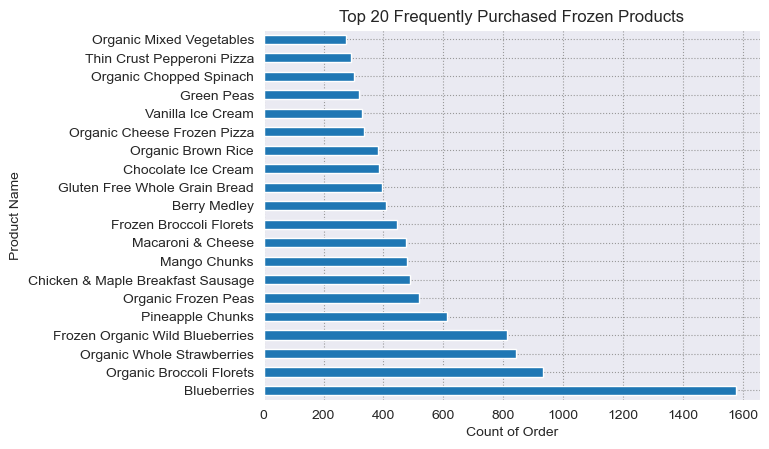

In [74]:
# Find the most popular frozen items with the highest demand 
df[df['frozen'] == 1]['product_name'].value_counts()[:20].plot(kind='barh')
plt.title('Top 20 Frequently Purchased Frozen Products')
plt.ylabel('Product Name')
plt.xlabel('Count of Order')
plt.show()

While there is a total of 3,079 frozen items identified in the dataset, we are only allowed to select 100 items for the Instabasket section. This means that the machine learning model must be able to select the top 100 most relevant frozen items to satisfy the constraint. 

## 7.2 Fresh Items 

Assuming that all dairy, meat, and produce are fresh/perishable items which need to be refridgerated. 

In [75]:
# Identify the departments that have fresh items 
fresh_dept = ['dairy eggs', 'produce', 'meat seafood', 'deli']

# Create a list of potentially fresh items that need to be refridgerated
# Ensure that there is no overlapping between refridgerated and frozen items
fresh = []

# Looping through each row to label fresh items based on their department 
for i in range(df.shape[0]):
    if df['department'].iloc[i] in fresh_dept:
        if df['frozen'].iloc[i] == 0:
            fresh.append(1)
        else:
            fresh.append(0)
    else: 
        fresh.append(0)    

In [76]:
# Add the fresh column to the dataset 
df['fresh'] = fresh

In [77]:
# Find the total number of fresh/perishable products that require refridgeration
fresh_products_count = df.groupby('fresh')['product_name'].nunique()[1]
total_product_count = df['product_id'].nunique()
print(f"There is a total of {fresh_products_count} fresh/perishable products out of {total_product_count} products in the dataset.") 
print(f"The number of fresh/perishable products accounted for {round(fresh_products_count/total_product_count*100,2)}% of all products in the dataset.")

There is a total of 5971 fresh/perishable products out of 34050 products in the dataset.
The number of fresh/perishable products accounted for 17.54% of all products in the dataset.


The calculations above show that there is a total of 5,971 unique fresh products in the dataset under the assumption that all products from the: dairy eggs, meat seafood, deli, and produce departments are perishable items. 

Compared to the amount of frozen items which accounted for 9.0% of all products in the dataset, fresh items made up of a significantly larger portion of 17.5% of the dataset. 

However, only 100 out of 5,871 fresh products can be selected for the Instabasket section. The limited spaces avaialble for refridgerated products would pose a great challenge for the selection process.  

In [78]:
# Find the total number of aisles that carry fresh items 
print(f"There is a total of {df.groupby('fresh')['aisle'].nunique()[1]} aisles that carry fresh items.")

There is a total of 27 aisles that carry fresh items.


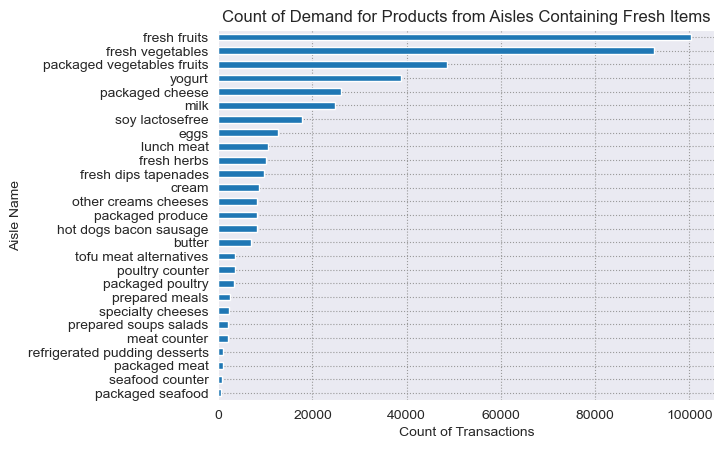

In [79]:
# Find the aisles that the fresh items associated with 
df.groupby('fresh')['aisle'].value_counts()[1].sort_values().plot(kind='barh')
plt.title('Count of Demand for Products from Aisles Containing Fresh Items')
plt.xlabel('Count of Transactions')
plt.ylabel('Aisle Name')
plt.show()

Upon further inspection and the use of common sense, the names of 27 aisles carrying perishable products all suggest that these aisles contain fresh products that need to be refridgerated. Thereby, none of these aisles can be dropped from the list of items that require refridgeration. 

Especially, the 'fresh fruits' and 'fresh vegetables' have signficantly high demands compared to other aisles. When it comes to substitutes, the labels of the aisles can help with finding relevant products that contain the same ingredients. If the closest substitutes cannot be found in the same aisle/department, these similar aisles can be the next closest item for the subsitutes. 

In [80]:
# Find the name of all aisles that contain the labels 'fruits'
# Create variables to store the sub-string that need to be searched
fruits_str = 'fruits'

# Find the substring by using the string find method 
index_1 = df['aisle'].str.find(fruits_str)

# Convert the indices to a binary format where 
# 1 represents products that are taken from aisle with a 'fruits' label
# 0 represents products that are not taken from aisle with a 'fruits' label  
df['fruits'] = np.where(index_1 == -1, 0, 1)

In [81]:
print(f" List of aisles names that contain the label 'fruits': {df.groupby('fruits')['aisle'].unique()[1]}.")

 List of aisles names that contain the label 'fruits': ['fresh fruits' 'packaged vegetables fruits'
 'bulk dried fruits vegetables'].


In [82]:
# Find the name of all aisles that contain the labels 'vegetables'
# Create variables to store the sub-string that need to be searched
vegetables_str = 'vegetables'

# Find the substring by using the string find method 
index_1 = df['aisle'].str.find(vegetables_str)

# Convert the indices to a binary format where 
# 1 represents products that are taken from aisle with a 'vegetables' label
# 0 represents products that are not taken from aisle with a 'vegetables' label  
df['vegetables'] = np.where(index_1 == -1, 0, 1)

In [83]:
print(f" List of aisles names that contain the label 'vegetables': {df.groupby('vegetables')['aisle'].unique()[1]}.")

 List of aisles names that contain the label 'vegetables': ['fresh vegetables' 'packaged vegetables fruits'
 'canned jarred vegetables' 'bulk dried fruits vegetables'].


## 7.3 Organic Items

Based on the NLP model analyzing product names above, the term 'organic' is frequently found as a label on the product names. Thus, to further understand the prevelance of organic items in the dataset, I will further explore: 
- Which organic products have the highest demand? 
- How many different organic products the dataset have?
- How many transactions(*) in the dataset contain an organic item?

(*) Note: Since an order may contain many transactions, I will use the term 'transaction' to refer to each item that appear in an order. 

In [84]:
# Create variables to store the sub-string that need to be searched
organic_str_low = 'organic'
organic_str_up = 'Organic'

# Find the substring by using the string find method 
index_1 = df['product_name'].str.find(organic_str_low)
index_2 = df['product_name'].str.find(organic_str_up)

# Convert the indices to a binary (0,1) format 
index_1_bin = np.where(index_1 == -1, 0, 1)
index_2_bin = np.where(index_2 == -1, 0, 1)

# Combine the two binary series together to indicate an organic item 
# Add the organic column to the dataframe 
df['organic'] = np.logical_or(index_1_bin, index_2_bin)

In [85]:
# Find the total number of organic products in the dataset
organic_products_count = df.groupby('organic')['product_name'].nunique()[1]
total_product_count = df['product_id'].nunique()
print(f"There is a total of {organic_products_count} organic products out of {total_product_count} products in the dataset.") 
print(f"The number of organic products accounted for {round(organic_products_count/total_product_count*100,2)}% of all products in the dataset.")

There is a total of 4026 organic products out of 34050 products in the dataset.
The number of organic products accounted for 11.82% of all products in the dataset.


In [86]:
# Find the portion of organic products out of all records in the dataset 
percent_organic = df['organic'].mean()*100
print(f"Organic products accounted for {round(percent_organic,2)}% of transactions in the dataset.")

Organic products accounted for 31.46% of transactions in the dataset.


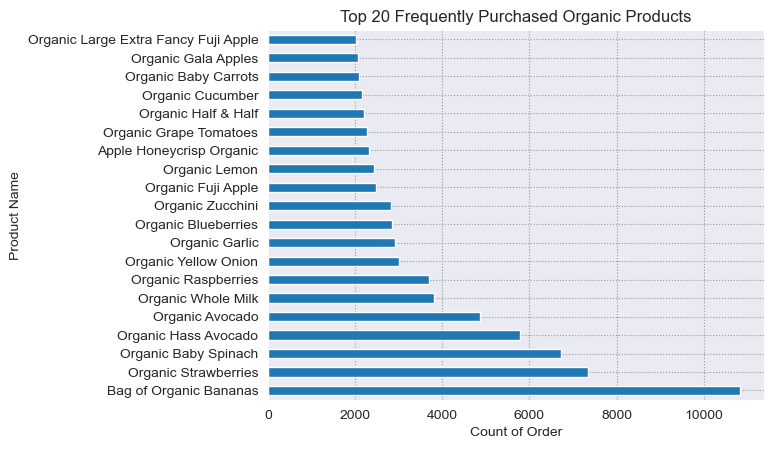

In [87]:
# Find the most popular organic products
df[df['organic'] == 1]['product_name'].value_counts()[:20].plot(kind='barh')
plt.title('Top 20 Frequently Purchased Organic Products')
plt.ylabel('Product Name')
plt.xlabel('Count of Order')
plt.show()

The bar chart above shows that a majority of organic products that are frequently purchased are fruits and vegetables. 

In [88]:
df.groupby('organic')['product_name'].nunique()

organic
False    30024
True      4026
Name: product_name, dtype: int64

In [89]:
# Find the departments that carry the most to least organic items  
dept_with_organic = df.groupby(['organic', 'product_name'])['department'].unique()[1].values

# Retrieve a list of department names 
dept_with_organic_names = [dept_with_organic[i][0] for i in range(len(dept_with_organic))]

# Create a dictionary to store the number of organic products each department have 
dept_organic_count = {}

# Looping through the list of department names to add them as a key to the dictionary 
for dept in df['department'].unique():
    dept_organic_count[dept] = 0

# Looping through the list of organic items' department names to count the number of organic products in each department
for dept_name in dept_with_organic_names:
    dept_organic_count[dept_name] +=1    

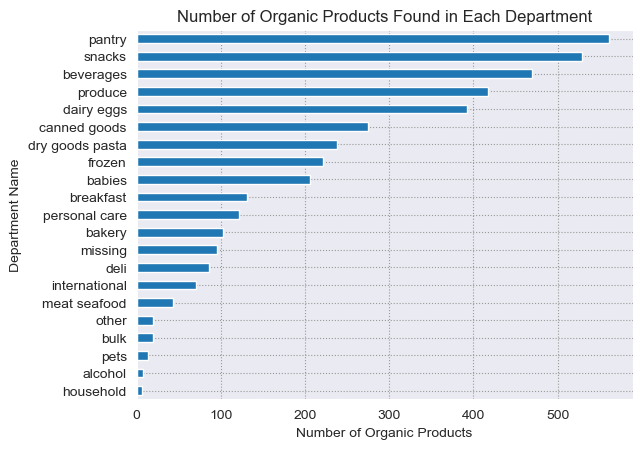

In [90]:
# Plot a bar chart to show the count of organic products found in each department 
pd.DataFrame.from_dict(dept_organic_count, orient='index', columns=['organic_product_count']).sort_values(by='organic_product_count').plot(kind='barh', legend=None)
plt.title('Number of Organic Products Found in Each Department')
plt.ylabel('Department Name')
plt.xlabel('Number of Organic Products')

plt.show()

Although the produce department has a high number of organic products with high demand, this department does not have as many organic products as the pantry, snacks, and beverages department. 

In addition, every department in the dataset contain at least 1 organic product which further highlight the prevalence of organic products for Instacart shoppers. 

# 8. Preparing data for clustering machine learning algorithm

To be able to compare each orders in the dataset to each other, each row of record of the processed dataset will contain information about one order instead of having multiple products assciated with an order listed out in each row. 

The features that the processed dataset will have to aid with clustering will be: 
- Order size: this attribute stores the total number of products requested in each order. 
- Number of fresh/perishable items. 
- Number of frozen items. 
- Number of organic items. 
- Number of items with the word 'fruits' in their names.
- Number of items with the word 'vegetables' in their names.
- Missing: binary variable to indicate items belonging to a 'missing' or 'other' department. 
- Number of aisles the products in the order belongs to. 
- Dummy variables to represent 17 departments (excluding: frozen, missing, other).
- Dummy variables to represent 134 aisles. 

In [91]:
# Create a cleaned dataset which only contain numerical values 
# Each row in this dataset represent a single order from the initial dataset 

cleaned_df = pd.DataFrame([])

## 8.1 Order sizes

In [92]:
# Create the order sizes attribute by grouping the records by order_id 
order_size = df.groupby('order_id')['product_name'].nunique().values

In [93]:
# Add the order sizes attribute to the cleaned dataset
cleaned_df['order_size'] = order_size

## 8.2 Number of perishable/fresh items

In [94]:
# Count the number of refridgerated items requested in each order
# Group the records by the order_id then take a sum of the 'fresh' binary column associated with the order
num_fresh = df.groupby('order_id')['fresh'].sum()

In [95]:
# Add the count of perishable/fresh items to the cleaned dataset 
cleaned_df['num_refridgerated'] = num_fresh

## 8.3 Number of frozen items

In [96]:
# Count the number of frozen items requested in each order
# Group the records by the order_id then take a sum of the 'frozen' binary column associated with the order
num_frozen = df.groupby('order_id')['frozen'].sum()

In [97]:
# Add the number of frozen items attribute to the cleaned dataset 
cleaned_df['num_frozen'] = num_frozen

## 8.4 Number of organic items 

In [98]:
# Count the number of organic items requested in each order
# Group the records by the order_id then take a sum of the 'organic' binary column associated with the order
num_organic = df.groupby('order_id')['organic'].sum()

In [99]:
# Add the number of organic items attribute to the cleaned dataset 
cleaned_df['num_organic'] = num_organic

## 8.5 Presence of items in aisles with 'fruits' label

In [100]:
# Count the number of items with the label 'fruits' in their aisles' names
# Group the records by the order_id then take a sum of the 'fruits' binary column associated with the order
num_fruits = df.groupby('order_id')['fruits'].sum()
# Use numppy where function to place binary values in the column 
fruits_aisles = np.where(num_fruits > 0, 1, 0)

In [101]:
# Add the number of fruit items to the cleaned dataset 
cleaned_df['num_fruits_products'] = num_fruits 

## 8.6 Presence of items in aisles with 'vegetables' label

In [102]:
# Count the number of items with the label 'vegetables' in their aisles' names
# Group the records by the order_id then take a sum of the 'vegetables' binary column associated with the order
num_vegetables = df.groupby('order_id')['vegetables'].sum()
# Use numppy where function to place binary values in the column 
vegetables_aisles = np.where(num_vegetables > 0, 1, 0)

In [103]:
# Add the number of vegetables items to the cleaned dataset 
cleaned_df['num_vegetables_products'] = num_vegetables

## 8.7 Number of items belonging to the 'missing' or 'other' department

In [104]:
# Use a for-loop to label transactions involving an item from the missing or other department 
ambiguous_dept_names = ['missing', 'other']
ambiguous_dept = []

for i in range(df.shape[0]):
    if df['department'].iloc[i] in ambiguous_dept_names:
        ambiguous_dept.append(1)
    else:
        ambiguous_dept.append(0)    

In [105]:
# Add the ambiguous department binary column to the dataframe 
df['ambiguous_dept'] = ambiguous_dept

In [106]:
# Use the groupby method to take a sum of the number of items coming from an ambiguous department in each order
num_ambiguous = df.groupby('order_id')['ambiguous_dept'].sum()

In [107]:
# Add the number of products coming from an ambiguous aisle to the cleaned dataset
cleaned_df['num_ambiguous_products'] = num_ambiguous

## 8.8 Number of aisles the products in the order belong to

In [108]:
num_aisles = df.groupby('order_id')['aisle'].nunique()

In [109]:
# Add the number of aisles that items from an order have to the cleaned dataset 
cleaned_df['aisles'] = num_aisles

## 8.9 Number of departments the products in the order belong to

In [110]:
num_dept = df.groupby('order_id')['department'].nunique()

In [111]:
# Add the number of departments that items from an order have to the cleaned dataset
cleaned_df['departments'] = num_dept

## 8.10 Dummy variables for departments 

In [112]:
# Create dummy variables to identify the department that an item belongs to 
dept_dummies = pd.get_dummies(df['department'], prefix='dept')

In [113]:
# Add an order_id column to the dept_dummies dataframe
dept_dummies['order_id'] = df['order_id']

In [114]:
dept_dummies.columns[:-1]

Index(['dept_alcohol', 'dept_babies', 'dept_bakery', 'dept_beverages',
       'dept_breakfast', 'dept_bulk', 'dept_canned goods', 'dept_dairy eggs',
       'dept_deli', 'dept_dry goods pasta', 'dept_frozen', 'dept_household',
       'dept_international', 'dept_meat seafood', 'dept_missing', 'dept_other',
       'dept_pantry', 'dept_personal care', 'dept_pets', 'dept_produce',
       'dept_snacks'],
      dtype='object')

In [115]:
dept_dummies_dict = {}

for department in dept_dummies.columns[:-1]:
    dept_dummies_dict[department] = dept_dummies.groupby('order_id')[department].sum().values

In [116]:
dept_by_orders = pd.DataFrame.from_dict(dept_dummies_dict)

In [117]:
# Add the dummies to the cleaned dataset
cleaned_df = pd.concat([cleaned_df,dept_by_orders], axis=1)

## 8.11 Dummy variables for aisles

In [118]:
# Create dummy variables to identify the aisle that an item belongs to 
aisle_dummies = pd.get_dummies(df['aisle'], prefix='aisle')

In [119]:
# Add an order_id column to the aisle_dummies dataframe
aisle_dummies['order_id'] = df['order_id']

In [120]:
aisle_dummies_dict = {}

for aisle in aisle_dummies.columns[:-1]:
    aisle_dummies_dict[aisle] = aisle_dummies.groupby('order_id')[aisle].sum().values

In [121]:
aisle_by_orders = pd.DataFrame.from_dict(aisle_dummies_dict)

In [122]:
# Add the dummies to the cleaned dataset
cleaned_df = pd.concat([cleaned_df,aisle_by_orders], axis=1)

# 9. Generate dataset for ML models

Before exporting the the cleaned dataset for further analysis and model building, I will check to see whether the data is entered in the correct format with an accurate number of rows and columns.

In [123]:
# Fill null values with zeroes 
cleaned_df = cleaned_df.fillna(0)

In [124]:
# Explore the shape of the cleaned dataset 
print(f"The cleaned dataset contains {cleaned_df.shape[1]} attributes and {cleaned_df.shape[0]} records.")

The cleaned dataset contains 164 attributes and 94653 records.


In [127]:
# Check to see whether the number of rows in the cleaned dataset is equal to the number of unique order_ids in the initial dataset
cleaned_df.shape[0] == df['order_id'].nunique()

True

The checks show that the dataset is accurately encoded and ready to be exported. 

In [128]:
# Export the processed dataframe as a csv file 
from pathlib import Path  
filepath = Path('cleaned_df.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
cleaned_df.to_csv(filepath)  